# HONIR CCD gain

2013/01分を再解析

2020/10/26 H. Akitaya (PERC/CIT)

In [1]:
from astropy.io import fits
import numpy as np
import glob

In [2]:
files = glob.glob('/home/akitaya/w7/honir/exam/ccdgain201301/*_bt.fits')  # Pre/over-scan region removed images (using hpkossub.py).

In [3]:
files

['/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140061opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140062opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140063opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140064opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140065opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140066opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140067opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140068opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140069opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140070opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140071opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140072opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140073opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140074opt00_bt

69-79の奇数番を使用 (当時のメモより。光源安定)

In [4]:
fns_testimgs = files[8:]
fns_testimgs = fns_testimgs[::2]

In [5]:
fns_testimgs

['/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140069opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140071opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140073opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140075opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140077opt00_bt.fits',
 '/home/akitaya/w7/honir/exam/ccdgain201301/HN1301140079opt00_bt.fits']

In [6]:
imgs_testimgs_bt = []
for fn in fns_testimgs:
    hdul = fits.open(fn)
    imgs_testimgs_bt.append(hdul[0].data)

In [7]:
imgs_testimgs_bt_ndarray = np.stack(imgs_testimgs_bt)
del(imgs_testimgs_bt)

In [8]:
testimg_bt_median = np.median(imgs_testimgs_bt_ndarray, axis=0)

In [9]:
testimg_bt_std = np.std(imgs_testimgs_bt_ndarray, axis=0)

In [10]:
img_ave = np.average(testimg_bt_median)
img_std = np.average(testimg_bt_std)

In [11]:
img_ave, img_std, testimg_bt_median.max()

(16413.074, 42.520245, 65421.0)

In [12]:
testimg_bt_median.shape

(4223, 2048)

In [13]:
np.max(testimg_bt_median)

65421.0

In [14]:
import matplotlib.pyplot as plt

In [15]:
plt.imshow(testimg_bt_median, vmin=-1000, vmax = img_ave*2)

In [16]:
testimg_bt_dev = testimg_bt_std **2

In [17]:
plt.imshow(testimg_bt_dev, vmin=000, vmax=5000)

In [18]:
img_ysize = testimg_bt_median.shape[0]

In [19]:
img_xsize = testimg_bt_median.shape[1]

In [20]:
img_xsize_per_ch = int(img_xsize /2)

In [21]:
print(img_xsize, img_ysize, img_xsize_per_ch)

2048 4223 1024


In [22]:
sample_xwidth_per_ch = 256

In [23]:
def get_sample_regions(imgdata, n_port, img_xsize_per_ch, sample_xsize_per_ch):
    """
    n_port: 1-4
    """
    n_ch = n_port -1
    xmin = img_xsize_per_ch * n_ch +int(img_xsize_per_ch/2) - int(sample_xsize_per_ch/2)
    xmax =  img_xsize_per_ch * n_ch +int(img_xsize_per_ch/2) + int(sample_xsize_per_ch/2)
    return imgdata[:, xmin:xmax+1]

In [24]:
n_port = 1

In [25]:
array_sig = get_sample_regions(testimg_bt_median, n_port, img_xsize_per_ch, sample_xwidth_per_ch).ravel()
array_dev = get_sample_regions(testimg_bt_dev, n_port, img_xsize_per_ch, sample_xwidth_per_ch).ravel()

In [26]:
array_sig.max()

64009.23

In [27]:
array_sig.shape, array_sig.max()

((1085311,), 64009.23)

In [28]:
array_dev.shape

(1085311,)

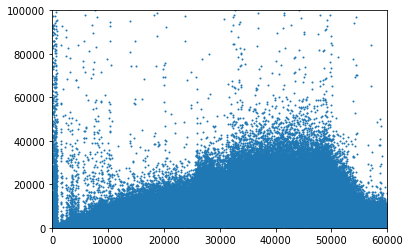

In [29]:
plt.ylim([0, 100000])
plt.xlim([0, 60000])
plt.scatter(array_sig, array_dev, s=1)

In [30]:
x_bin_width = 100

In [31]:
np.max(array_sig)

64009.23

In [32]:
x_max_calc = np.floor(np.max(array_sig)/x_bin_width-1)*x_bin_width

In [33]:
x_max_calc

63900.0

In [34]:
sig_all = []
dev_all = []
err_all = []
x = 0
while (x<= x_max_calc):
    #print(x)
    data_index = ((array_sig > x) & (array_sig <= x+x_bin_width))
    x += x_bin_width
    #print(data_index)
    #and array_sig <= (x+x_bin_width))
    sig_data_prt = array_sig[data_index]
    dev_data_prt = array_dev[data_index]
    
    trues = data_index[data_index==True]
    n_sample = len(trues)
    if n_sample == 0:
        continue
    sig = np.median(sig_data_prt)
    dev = np.median(dev_data_prt)
    error = np.std(dev_data_prt)/np.sqrt(n_sample-1)
    print(sig, dev, error, n_sample)
    sig_all.append(sig)
    dev_all.append(dev)
    err_all.append(error)

34.59047 12.647483 20.56129910264751 119856
142.91666 42.075764 67.76115055760123 66445
243.13773 68.8774 17.412949186050724 82406
331.29327 93.79152 125.77200724827868 25894
478.5769 129.3358 11.905888631603533 16525
541.4372 152.11168 39.801291384967136 40668
648.5357 179.27911 19.899277605332045 29495
745.3571 204.44225 20.711653210890407 22565
844.61536 235.1332 64.33996167428398 13252
946.54016 261.15073 2.061436077629833 8445
1045.2437 281.58173 2.593795524166274 6651
1145.7448 320.0812 3.3981814994488024 4409
1244.6896 344.78787 4.9513348009261335 2551
1350.2213 367.24762 5.917857047193152 2100
1461.0099 399.72708 12.37159965571961 3366
1550.0898 431.92947 34.80348039887685 4435
1649.7144 453.06842 27.5720534164675 4787
1744.6288 475.27225 5.752711476341964 3593
1849.0422 505.067 471.7946606070951 3001
1948.1853 535.02185 78.60107942280467 2694
2049.05 558.26196 8.323756201496153 2385
2150.5364 596.0144 9.148458556709414 2146
2248.9097 603.2446 9.985784265589619 1984
2348.475 63

19649.867 5236.845 432.4843635704072 589
19749.219 5261.0957 199.39095787064022 574
19849.492 5172.117 251.46991244815155 566
19950.387 5232.8955 2563.9607595480875 586
20051.61 5293.012 1038.6831843763648 553
20146.703 5160.641 548.4790883616939 534
20249.965 5108.0205 639.9773656297158 560
20351.541 5272.1367 245.75878260028966 517
20449.648 5116.199 245.9967975989555 573
20549.553 5153.433 158.82162329103915 555
20650.55 5400.0107 171.77579555111078 543
20748.338 4943.953 174.654305835116 534
20851.209 5199.0137 165.38585956291948 537
20949.64 5500.154 189.70775656773816 520
21051.922 5537.9365 272.8580007687048 500
21150.5 5376.156 167.56916900175275 522
21250.594 5204.8984 190.7425006216993 525
21350.88 5281.6772 152.5818953442757 547
21450.418 5620.033 184.32498641051208 500
21548.006 5601.836 170.9165405972978 509
21648.607 5608.7007 182.75347549713564 501
21748.107 5658.393 195.52399319041515 449
21847.652 5338.5425 182.74303868942883 456
21947.645 5563.673 193.9551856485131 48

39449.598 9637.772 234.26777230319698 985
39550.05 10061.204 220.92020539314515 962
39649.43 9889.624 231.95609249677244 943
39750.746 10094.3955 236.48530007927576 972
39849.13 10167.709 235.5507894063478 978
39950.5 10064.05 237.847286533578 1019
40052.945 9550.544 297.4247376580248 998
40150.508 10036.708 365.2803031666792 987
40247.97 10420.925 263.54405629824316 921
40351.46 9741.526 338.4929400520339 959
40451.06 10341.47 238.5039445322981 1015
40550.32 9713.791 257.55213211412536 952
40650.97 9757.037 272.9394445044423 967
40749.28 9695.715 235.76444934048104 980
40850.645 9838.497 220.9400554881572 968
40948.734 9985.415 246.08966528237227 977
41051.508 9841.798 241.33152522945116 1049
41147.387 10162.799 237.50949387161057 940
41248.383 9843.183 237.90511743186596 991
41351.06 10036.99 250.02042716928958 1012
41447.55 9622.307 257.22895696153955 982
41549.9 10013.123 237.22381969902494 1014
41651.367 10144.914 670.4384758856105 1009
41749.77 10011.215 270.76237729717553 1013
4

59246.066 2421.1313 62.164523842459054 1079
59348.953 2342.108 65.86004169309436 929
59445.508 2506.2947 76.87292552111728 631
59548.297 2260.841 86.50723489490332 589
59646.797 2233.7769 99.6773157833351 501
59744.785 2220.0933 85.6940667994339 452
59852.36 1958.9539 77.13276125722021 455
59952.242 1995.9199 77.14655945796788 498
60054.89 2020.5139 96.64002512434041 426
60149.473 2155.428 77.52319865222167 493
60249.15 2195.5332 76.97094474979635 452
60353.71 1914.0251 69.35992130781251 524
60448.93 1877.0382 73.10579873445666 477
60551.258 1983.8756 75.5497159090909 485
60650.57 1860.0878 78.6025875945492 497
60748.016 1992.4517 68.53715284171918 531
60849.805 2029.21 73.5380138483616 523
60950.64 1976.8865 69.60385590430765 472
61052.617 2146.0715 70.35699994578535 476
61149.324 1776.4956 50.645903543524604 637
61248.85 1785.1467 59.450706853919485 544
61350.105 1949.7922 76.90676451828769 607
61444.93 1882.342 86.61624034064515 548
61556.438 1840.5286 65.94962707627113 581
61652.77

In [35]:
plt.errorbar(sig_all, dev_all, yerr=err_all,  fmt="o")
plt.grid()
plt.xlabel('Count [ADU]')
plt.ylabel('Deviation [ADU^2]')
plt.xlim([0, x_max_calc])
plt.show()

In [36]:
from scipy import optimize

In [37]:
def photontransfer_curve(x, gain, ro):
    return x/gain + (ro/gain)**2

In [38]:
par, cov = optimize.curve_fit(photontransfer_curve, sig_all, dev_all,  sigma=err_all, p0=(0.1, 4.0))

In [39]:
par

array([ 18.37370123, 336.57877654])

In [40]:
cov

array([[  0.87248201,  20.64603841],
       [ 20.64603841, 711.93915568]])

In [41]:
x_fit = np.linspace(0, 2500, 26)

In [42]:
y_fit = photontransfer_curve(x_fit, par[0], par[1])

In [43]:
plt.errorbar(sig_all, dev_all, yerr=err_all,  fmt="o")
plt.plot(x_fit, y_fit)
plt.grid()
plt.xlabel('Count [ADU]')
plt.ylabel('Deviation [ADU^2]')
plt.xlim([0, x_max_calc])
plt.show()

In [44]:
def analyse_photontransfer_curve(sig_all, dev_all, err_all, p0=(3, 10.0), sig_max=None):
    sig_all_ndarray = np.array(sig_all)
    dev_all_ndarray = np.array(dev_all)
    err_all_ndarray = np.array(err_all)
    if sig_max != None:
        filter_matrix = sig_all_ndarray < sig_max
        sig_all_ndarray = sig_all_ndarray[filter_matrix]
        dev_all_ndarray = dev_all_ndarray[filter_matrix]
        err_all_ndarray = err_all_ndarray[filter_matrix]
    par, cov = optimize.curve_fit(photontransfer_curve, sig_all_ndarray, dev_all_ndarray, 
                                  sigma=err_all_ndarray, p0=p0, absolute_sigma=False)
    return par, cov

In [45]:
def plt_photontransfer_curve(sig_all, dev_all, err_all, par):
    x_fit = np.linspace(0, np.max(sig_all)*0.8, 100)
    y_fit = photontransfer_curve(x_fit, par[0], par[1])
    plt.grid()
    plt.xlabel('Count [ADU]')
    plt.ylabel('Deviation [ADU^2]')
    plt.xlim([0, x_max_calc])
    plt.ylim([0,10000])
    plt.errorbar(sig_all, dev_all, yerr=err_all,  fmt=".")
    plt.plot(x_fit, y_fit, color='r', linewidth=3)
    plt.show()

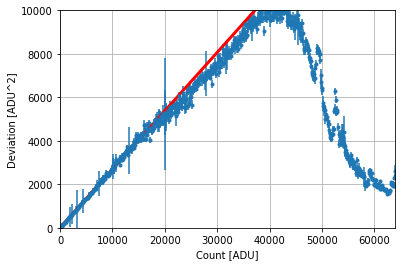

In [46]:
par, cov = analyse_photontransfer_curve(sig_all, dev_all, err_all, sig_max=20000)
plt_photontransfer_curve(sig_all, dev_all, err_all, par)

In [47]:
def get_sample_region(img_sig, img_dev, n_port, sample_xsize_per_ch=256):
    img = img_sig
    img_ysize = img.shape[0]
    img_xsize = img.shape[1]
    img_xsize_per_ch = int(img_xsize /4)
    n_ch = n_port -1
    xmin = int(img_xsize_per_ch * n_ch + img_xsize_per_ch/2 - sample_xsize_per_ch/2)
    xmax =  int(img_xsize_per_ch * n_ch + img_xsize_per_ch/2 + sample_xsize_per_ch/2)
    print('img_sig.shape {}'.format(img_sig.shape))
    print(xmin, xmax)
    array_sig = img_sig[:, xmin:xmax+1].ravel()
    array_dev= img_dev[:, xmin:xmax+1].ravel()
    return array_sig, array_dev

In [48]:
def calc_statistics_in_sample_region(array_sig, array_dev, count_bin_width=100):
    sig_all = []
    dev_all = []
    err_all = []
    count = 0
    count_max_calc = np.floor(np.max(array_sig)/count_bin_width-1)*count_bin_width
    while (count<= count_max_calc):
        #print(x)
        data_index = ((array_sig > count) & (array_sig <= count+count_bin_width))
        count += count_bin_width
        #print(data_index)
        #and array_sig <= (x+x_bin_width))
        sig_data_prt = array_sig[data_index]
        dev_data_prt = array_dev[data_index]
    
        trues = data_index[data_index==True]
        n_sample = len(trues)
        #print(n_sample)
        if n_sample == 0:
            continue
        sig = np.median(sig_data_prt)
        dev = np.median(dev_data_prt)
        error = np.std(dev_data_prt)/np.sqrt(n_sample-1)
       # print(sig, dev, error, n_sample)
        sig_all.append(sig)
        dev_all.append(dev)
        err_all.append(error)
    return sig_all, dev_all, err_all

## Calculate gains of the port 1-4

Port 1
img_sig.shape (4223, 2048)
128 384


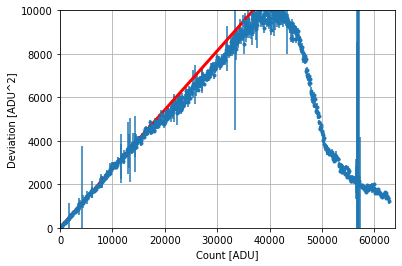

Port 2
img_sig.shape (4223, 2048)
640 896


Port 3
img_sig.shape (4223, 2048)
1152 1408


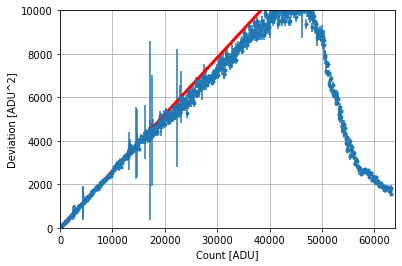

Port 4
img_sig.shape (4223, 2048)
1664 1920


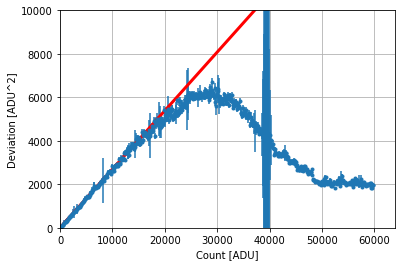

In [49]:
pars = []
covs = []

SIG_MAX = 15000.0  # Fitting range (mag).

for n_port in range(1, 5):
    print('Port {}'.format(n_port))
    array_sig, array_dev = get_sample_region(testimg_bt_median, testimg_bt_dev, n_port)
    sig_all, dev_all, err_all = calc_statistics_in_sample_region(array_sig, array_dev)
    par, cov = analyse_photontransfer_curve(sig_all, dev_all, err_all, sig_max=SIG_MAX)
    plt_photontransfer_curve(sig_all, dev_all, err_all, par)
    pars.append(par)
    covs.append(cov)

In [50]:
pars

[array([3.68778923, 6.23422145]),
 array([3.70839443, 8.27527124]),
 array([3.83751603, 9.49715363]),
 array([3.71446853, 9.12944499])]

In [51]:
covs

[array([[1.18760809e-04, 1.75271927e-02],
        [1.75271927e-02, 4.66051632e+00]]),
 array([[1.02521382e-04, 1.02641821e-02],
        [1.02641821e-02, 3.02655760e+00]]),
 array([[9.20429546e-05, 9.66560473e-03],
        [9.66560473e-03, 2.05026839e+00]]),
 array([[1.24717121e-04, 1.49940401e-02],
        [1.49940401e-02, 3.64789489e+00]])]

In [52]:
i=1
print('#ch gain [e/ADU] err_gain ro[e-] err_ro')
for par, cov in zip(pars, covs):
    print('{:1d} {:12.5f} {:12.5f} {:8.2f} {:8.2f}'.format(i, float(par[0]),  float(cov[0][1]), float(par[1]), float(cov[1][1])))
    i += 1

#ch gain [e/ADU] err_gain ro[e-] err_ro
1      3.68779      0.01753     6.23     4.66
2      3.70839      0.01026     8.28     3.03
3      3.83752      0.00967     9.50     2.05
4      3.71447      0.01499     9.13     3.65


当時の解析と1.5倍近く異なる。

    # CCD gain measurment
    # for 2013/01

    # 2013/03/01
    
    # ch1
    # 0-10000 ADU fit
    a               = 0.379947         +/- 0.005073     (1.335%)
    b               = -13.5493         +/- 28.45        (210%)
    gain 2.63194603457851 0.0351413808594798
    
    # ch2
    # 0-10000 ADU fit
    a               = 0.384998         +/- 0.008447     (2.194%)
    b               = -13.5508         +/- 46.35        (342%)
    gain 2.5974160904732 0.0569882797215235
    
    
    # ch3
    # 0-10000 ADU fit
    a               = 0.360213         +/- 0.005382     (1.494%)
    b               = 20.7648          +/- 31.77        (153%)
    gain 2.77613523109938  0.0414786801525121
    
    # ch4 
    # 0-10000 ADU fit
    a               = 0.36321          +/- 0.007142     (1.966%)
    b               = 20.5132          +/- 40.43        (197.1%)
    gain 2.75322816001762  0.0541382547805563
    
    # 4 chs
    average 2.6896813790422 0.088239664896097 4
